In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
plt.rcParams["figure.figsize"] = (30,30)
import scipy.stats as stats
import pickle
import timeit
SEED = 0
np.random.seed(SEED)
from sklearn.decomposition import PCA
from evaluate import get_mask, distance, add_noise, get_sparsity, add_saltpepper, normalize_matrix

In [ ]:
data_path = Path("/data/toulouse/scMultiSim/run_04")
out_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data")
run_id = "scMultiSim_data/run_04"
atac_base = pd.read_csv(data_path/"atac_counts.csv", index_col=0).to_numpy(np.float32)
grn = pd.read_csv(data_path/"geff.csv", index_col=0).to_numpy(np.float32)
region_to_gene = pd.read_csv(data_path/"region_to_gene.csv", index_col=0).to_numpy(np.float32)
region_to_tf = pd.read_csv(data_path/"region_to_tf.csv", index_col=0).to_numpy(np.float32)
atacseq_obs = pd.read_csv(data_path/"atacseq_obs.csv", index_col=0).to_numpy(np.float32)


filt_grn = pd.read_csv(out_path/run_id/"filtered_grn.csv", index_col=0).to_numpy(np.float32)
filt_region_to_gene = pd.read_csv(out_path/run_id/"filtered_region_to_gene.csv", index_col=0).to_numpy(np.float32)
filt_region_to_tf = pd.read_csv(out_path/run_id/"filtered_region_to_tf.csv", index_col=0).to_numpy(np.float32)
filt_atacseq_obs = pd.read_csv(out_path/run_id/"processed_atac.csv", index_col=0).to_numpy(np.float32)


atac_perturbed = atac_base[:,-600:]
atac_unpert = atac_base[:,:-600]
atac_obs_perturbed = atacseq_obs[:,-600:]
atac_obs_unpert = atacseq_obs[:,:-600]
filt_atac_perturbed = filt_atacseq_obs[:,-600:]
filt_atac_unpert = filt_atacseq_obs[:,:-600]

noise_region_to_gene = add_noise(region_to_gene)
noise_region_to_tf = add_noise(region_to_tf)


In [ ]:
corr = np.abs(np.corrcoef(atac_obs_perturbed))
plt.hist(corr)
plt.vlines(x=[np.percentile(corr, n) for n in range(0,110,10)], ymin=np.min(corr), ymax=400)
plt.vlines(np.percentile(corr, 100-get_sparsity(grn)*100), ymin=0, ymax=410, colors="red")
plt.show()

In [ ]:
np.percentile(np.arange(100), 0.196 *100)

In [ ]:
pca = PCA()
atac_transf = pca.fit_transform(atac_obs_unpert)
plt.bar(np.arange(pca.n_components_),height=pca.explained_variance_)


In [ ]:
threshold = 100-get_sparsity(grn)*100

In [ ]:
parameter_sets={
    #"params1" : {
    #    "correlation":False,
    #    "threshold" : False,
    #    "comment" : "without correlation matrix"
    #},
    "params2" : {
        "correlation":True,
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"with correlation matrix"
    },
    "params5" : {
        "pseudocounts":True,
        "correlation":False,
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"no correlation,\npseudocounts"
    },
    "params7" : {
        "pseudocounts":True,
        "correlation":True,
        "correlation_kwargs": {
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
                "threshold" : 0.4,
            },
        },
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix,\npseudocounts"
    },
    "params8" : {
        "pseudocounts":False,
        "correlation":True,
        "correlation_kwargs": {
            "threshold" : True,
            "threshold_kwargs": {
                "percentile": threshold,
            },
        },
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix thresholded"
    },
    "params9" : {
        "correlation":True,
        "correlation_kwargs": {
            "normalize" : True,
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
            },
        },
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"correlation matrix normalized"
    },
    "params10" : {
        "correlation":True,
        "correlation_kwargs": {
            "mask" : np.zeros((330, 330)) + np.diag(np.ones(330)), # depends on atac data shape
            "normalize":False,
            "threshold" : False,
            "threshold_kwargs": {
                "percentile": threshold,
                "threshold" : 0.4,
            },
        },
        "threshold" : True,
        "threshold_kwargs": {
            "percentile": threshold,
        },
        "comment":"no data"
    }
}

corr = np.abs(np.corrcoef(atac_base))
params_corr_threshold = {n:{
        "correlation":True,
        "correlation_kwargs": {
            "threshold" : True,
            "threshold_kwargs": {
                "percentile": threshold,
                "threshold" : n,
            },
        },
        "threshold" : False,
    } for n in np.arange(0, 1.1, 0.1)}

In [ ]:
N=10
replicates= 3
pca = PCA()
atac_transf = pca.fit_transform(atac_obs_unpert)
distances = np.empty((pca.n_components_, len(parameter_sets), N, replicates))
for r in range(replicates):
    for n in range(0, N):
        noise_region_to_gene = add_saltpepper(region_to_gene, n*0.01)
        noise_region_to_tf = add_saltpepper(region_to_tf, n*0.01)
        for c in range(1,pca.n_components_+1):
            masks ={key:get_mask(atac_transf[:,:c],
                                 noise_region_to_gene,
                                 noise_region_to_tf,
                                 **params,
                                 ) for key, params in parameter_sets.items()}

            #plt.hist(normalize_matrix(np.corrcoef(atacseq_obs, dtype=float)))
            #plt.xticks(np.arange(0, 2, 0.1))
            distances[c-1, ::, n, r]=[distance(grn, mask) for mask in masks.values()]
distances = distances.mean(axis=3)

comments =[x["comment"] for x in parameter_sets.values()]

masks ={key:get_mask(atac_obs_unpert,
                     add_saltpepper(region_to_gene,p=0.2),
                     add_saltpepper(region_to_tf,p=0.2),
                     **params,
                     ) for key, params in parameter_sets.items()}

#distances=[distance(grn, mask) for mask in masks.values()]
#print(distances)
fig, ax = plt.subplots(nrows=1, ncols=len(masks)+1)
ax = ax.flatten()
ax[0].imshow(grn)

ax[0].set_title("GRN")
ax[0].set_xlabel("TFs")
ax[0].set_ylabel("Genes")
for n, (key, mask) in enumerate(masks.items()):
    ax[n+1].imshow(mask)
    ax[n+1].set_xlabel("TFs")
    ax[n+1].set_ylabel("Genes")
    ax[n+1].set_title(comments[n])

fig.suptitle("Different mask creation parameters")
#fig.tight_layout()
#fig.subplots_adjust(top=0.88)
#fig.savefig(out_path/"figures"/"parameters_.pdf", format="pdf")


np.array


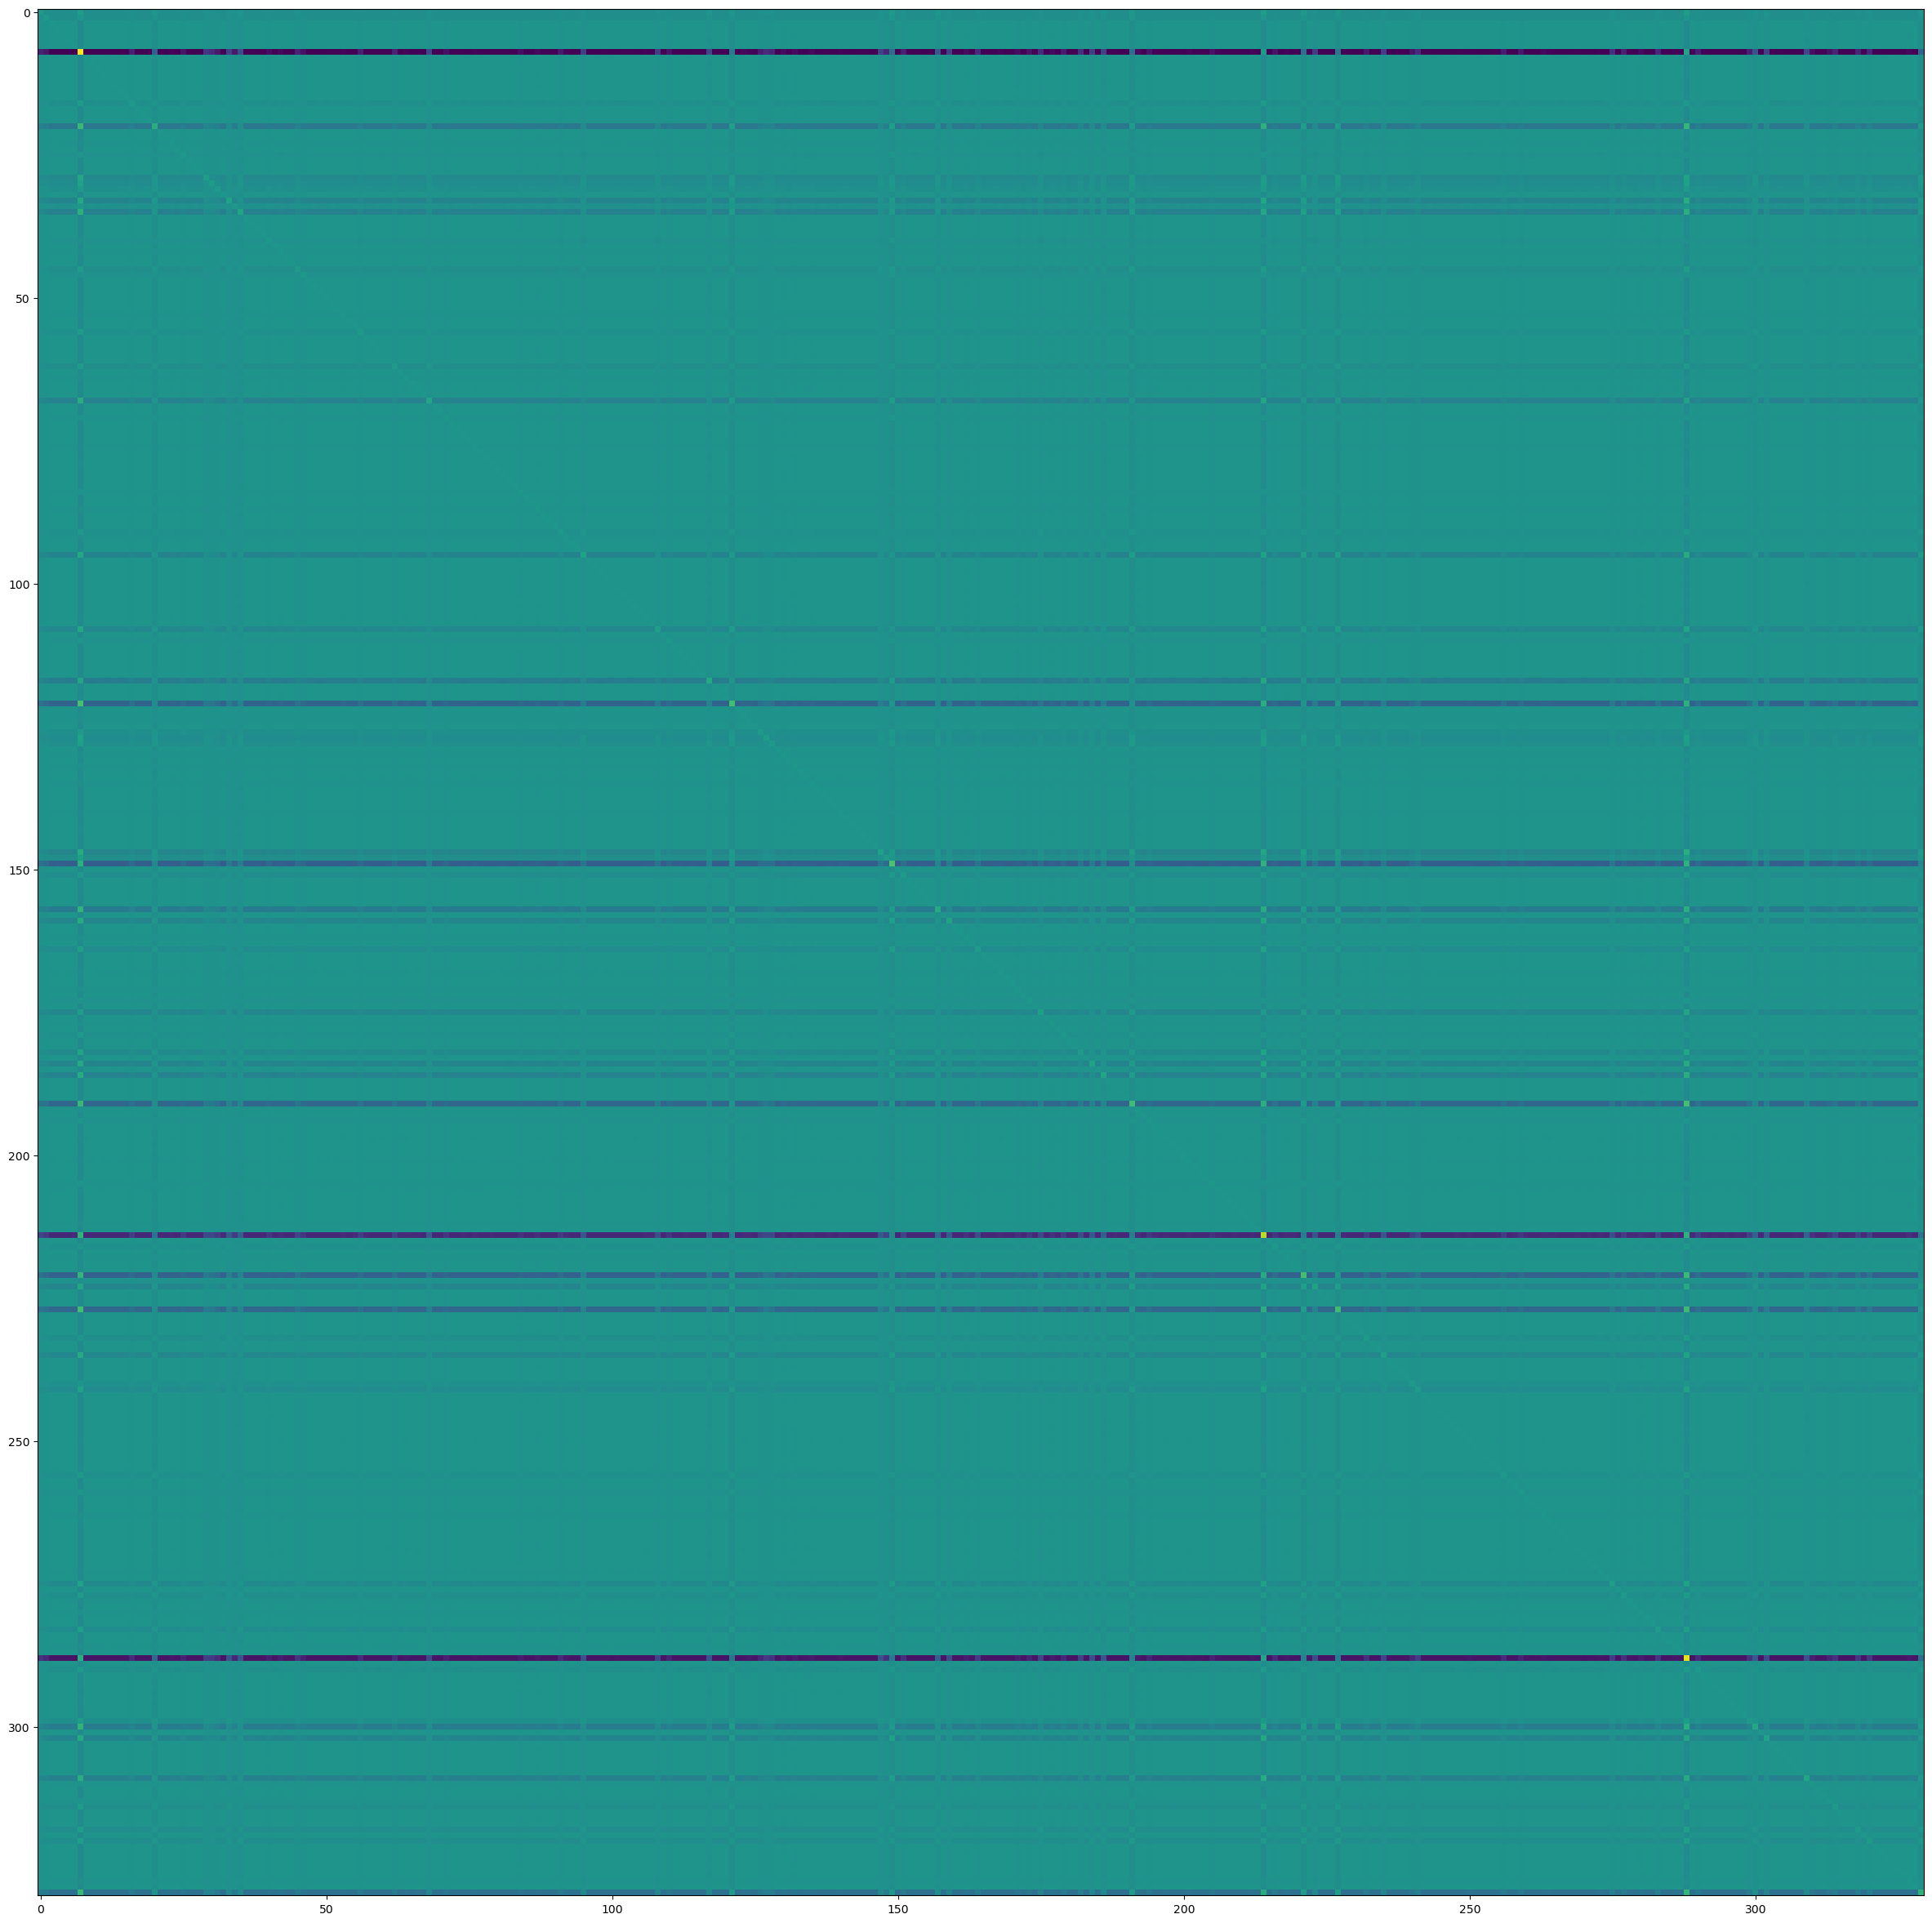

In [44]:
plt.imshow(normalize_matrix(np.corrcoef(atac_transf)),)

/data/toulouse/miniforge3/envs/multi-ome02/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/data/toulouse/miniforge3/envs/multi-ome02/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/data/toulouse/miniforge3/envs/multi-ome02/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


330
np.array


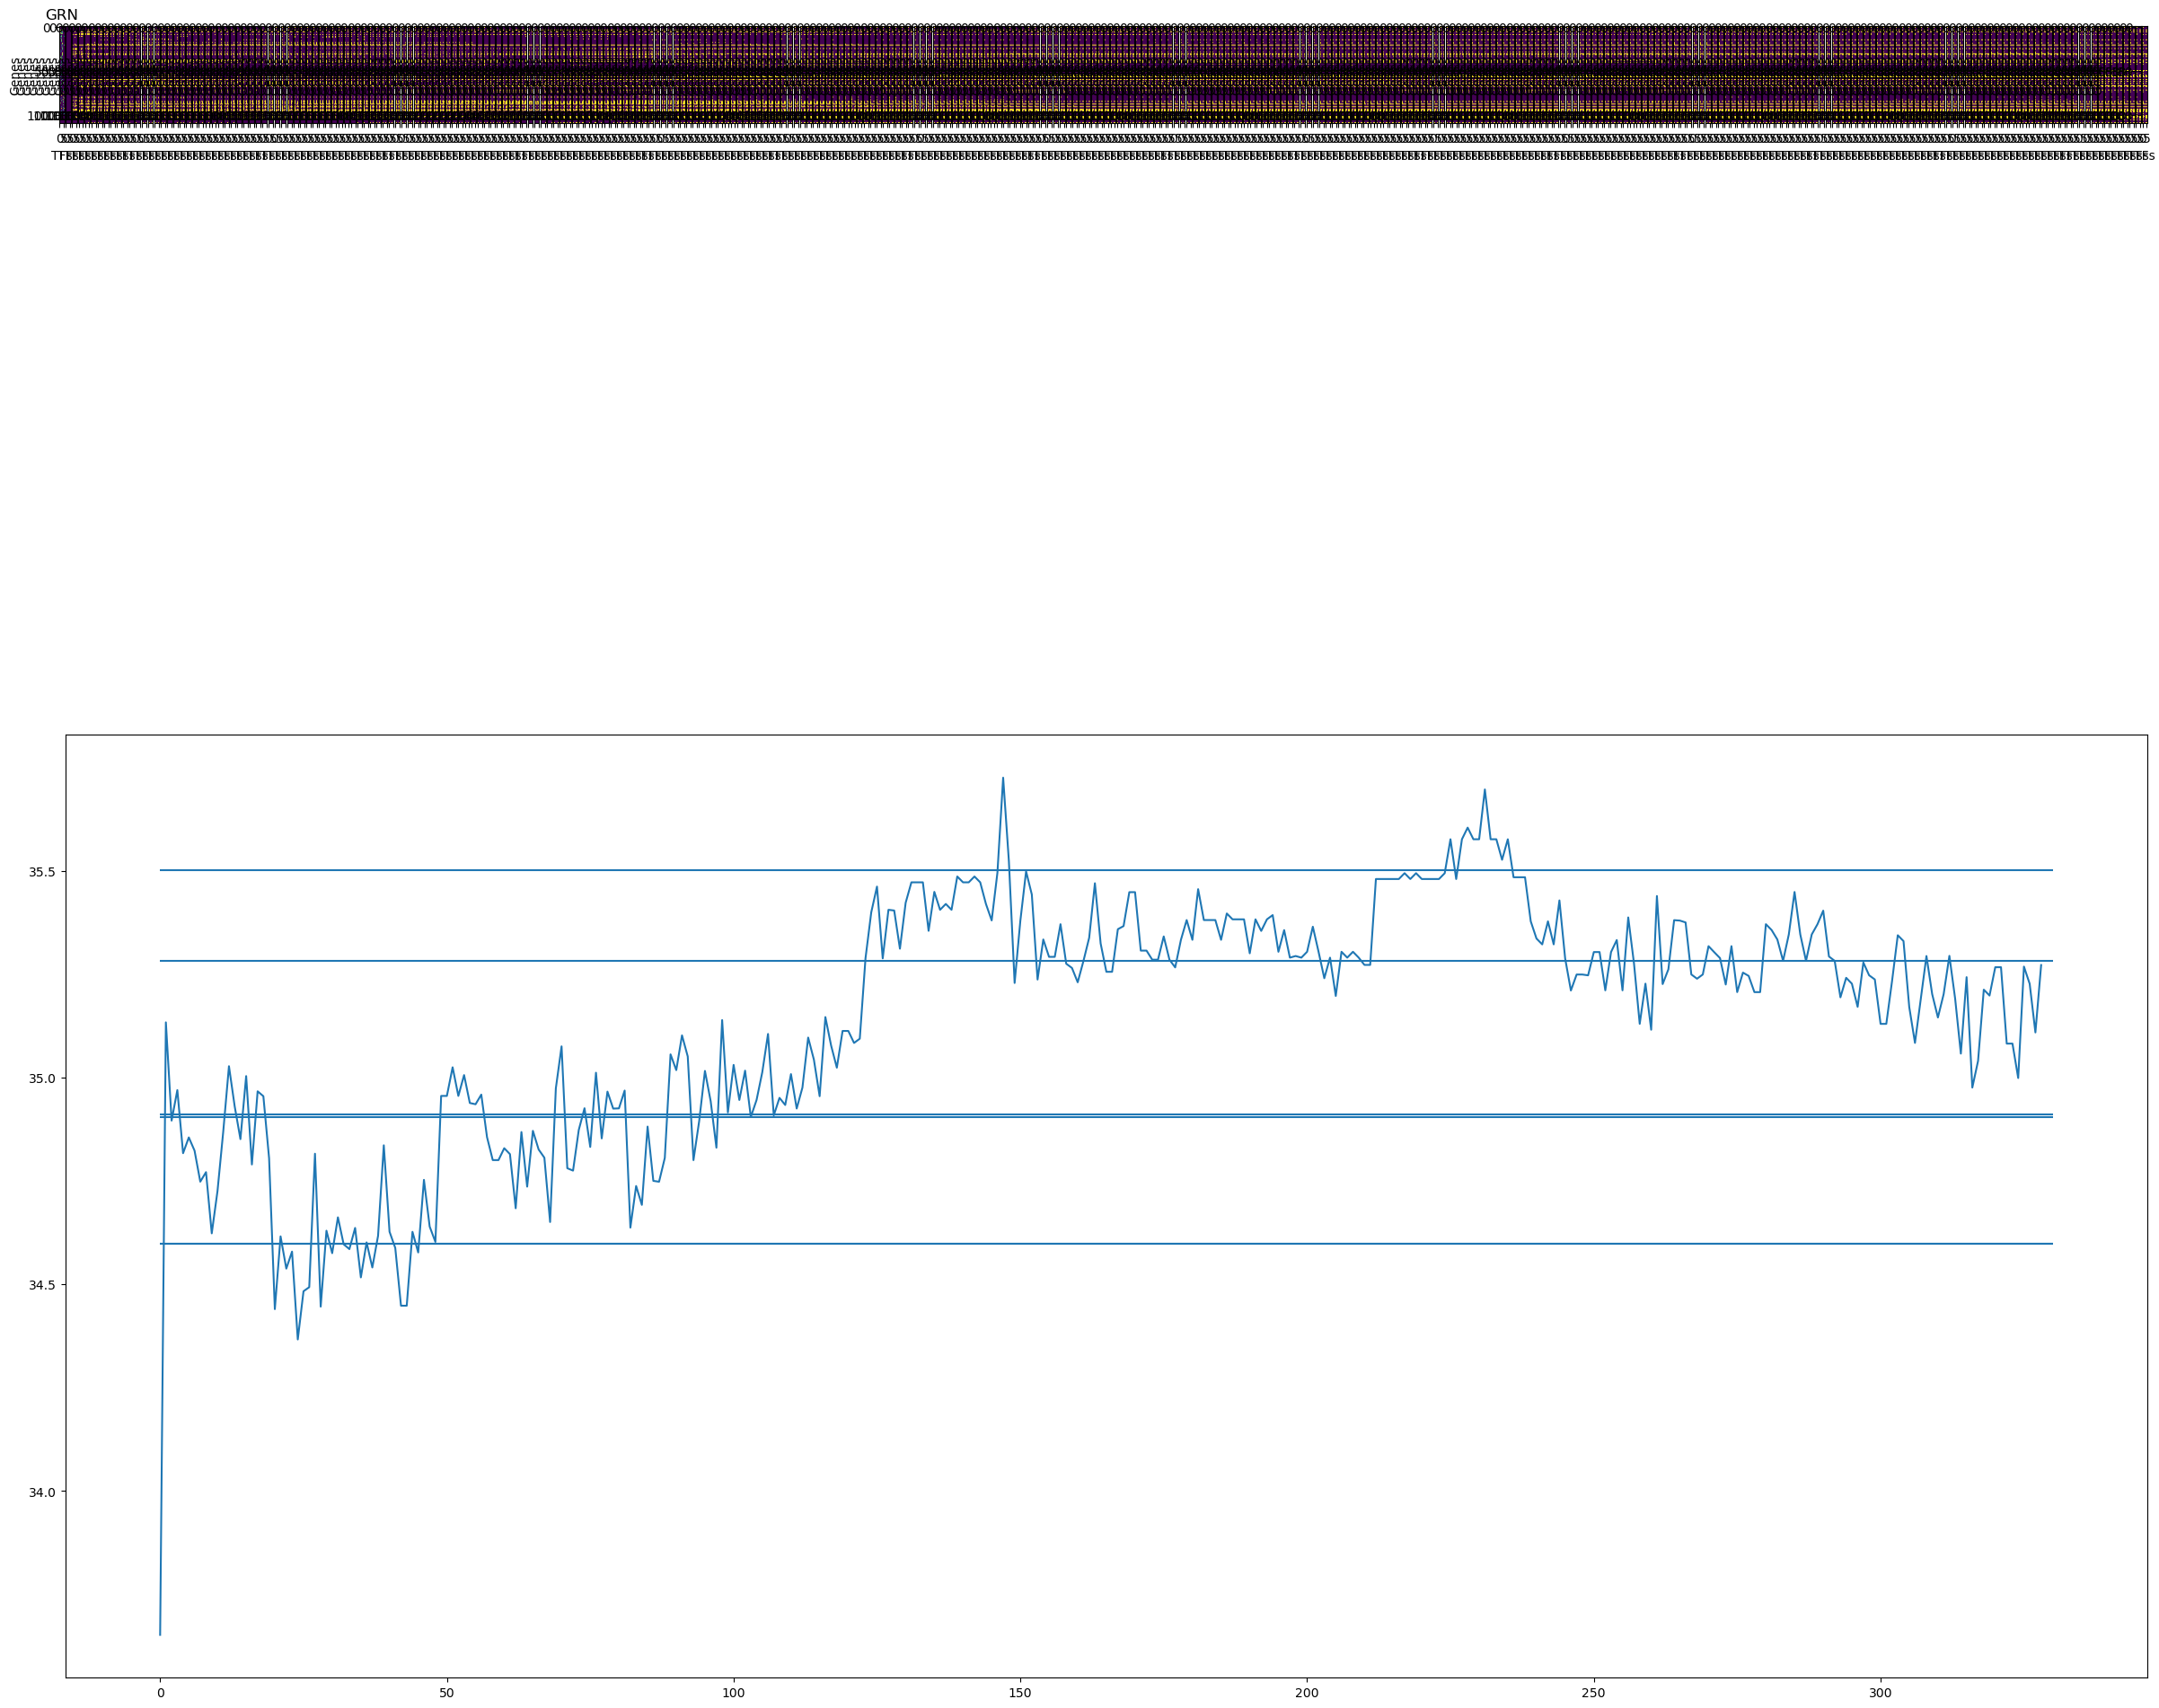

In [ ]:
noise_region_to_gene = add_noise(region_to_gene, std=0.01),
noise_region_to_tf = add_noise(region_to_tf, std=0.01),
masks = [get_mask(atac_transf[:, 0:n],
                  region_to_gene,
                  region_to_tf,
                  **parameter_sets["params8"]) for n in range(1,pca.n_components_)]
plt.figure()


plt.subplot(2, len(masks)+1, 1)
plt.imshow(grn)

plt.title("GRN")
plt.xlabel("TFs")
plt.ylabel("Genes")
for n, mask in enumerate(masks):
    plt.subplot(2, len(masks)+1, n+2)
    plt.imshow(mask)
    plt.xlabel("TFs")
    plt.ylabel("Genes")
    #plt.title(comments[n])
print(n+2)
plt.subplot(2, len(masks)+1,(n+4,(n+2)*2 ))
plt.plot(np.arange(len(masks)),[distance(grn, mask) for mask in masks])
plt.hlines([distance(grn, get_mask(atac_base, region_to_gene, region_to_tf, **params)) for params in parameter_sets.values()],
           xmin=0, xmax=pca.n_components_)




In [ ]:
plt.bar(range(pca.n_components_), pca.explained_variance_)

In [ ]:
min_comp = distances.argmin(axis=0)
print(min_comp.shape)
for t,p in enumerate(min_comp):
    plt.plot(np.arange(0, N), p, label=comments[t])
plt.legend()
plt.ylabel("number of PCs for minimum distance")
plt.xlabel("Noise")

In [ ]:
zero_distance = distance(grn, np.zeros(grn.shape))
one_distance = distance(grn, np.ones(grn.shape))

In [ ]:
#plt.imshow(masks["params4"])

In [ ]:
distances.shape

In [ ]:
mean = distances[0, :, :]
for t,p in enumerate(mean):
    plt.plot(np.arange(0, N*0.1, 0.1), p, label=np.array(comments)[t])
#plt.hlines(zero_distance, xmin=0, xmax=1, label="zero_distance")
#plt.hlines(one_distance, xmin=0, xmax=1, label="one_distance")
plt.legend(loc="center right")
plt.ylabel(" min distance")
plt.xlabel("std of added noise to framework")
plt.title("Distance with different amounts of framework noise")


In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=3)
#ax = ax.flatten()
colors = ["green", "red", "blue"]
for n in range(N):
    for t, c in enumerate(distances[:,:,n].T):
        plt.plot(np.arange(0, pca.n_components_), c,label=comments[t])
    #plt.hlines(zero_distance, xmin=0, xmax=300, label="zero_distance")
    #plt.hlines(one_distance, xmin=0, xmax=300, label="one_distance")
    plt.legend()
    #fig.align_ylabels()
    plt.title(f"Noise std: {n*0.1}")

    plt.show()